<a href="https://colab.research.google.com/gist/RVDeeneshKumar/14705f27d0a23a89a2326d51958b3dd5/skim_literature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Skimming Literature Paper** 

**Confirm access to a GPU**

Since a deep learning model is to be built, let's make sure a GPU is present.

In Google Colab, Runtime->Change runtime type-> Hardware accelerator->GPU.

# Get the data

DataSet: PubMed 200k RCT dataset

In [89]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [90]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Data Files:

`train.txt` -  training samples

`dev.txt` - development set/validation set

`test.txt` - test samples


In [91]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [92]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocessing Data

In [93]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [94]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [95]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [96]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 1.02 s, sys: 352 ms, total: 1.37 s
Wall time: 3.8 s


(180040, 30212, 30135)

In [97]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [98]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [99]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

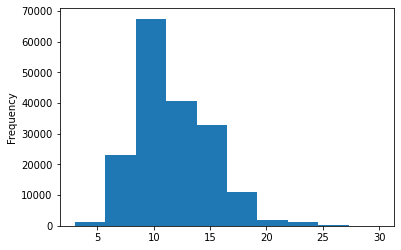

In [100]:
train_df.total_lines.plot.hist();

In [101]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [102]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [103]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [104]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [105]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [107]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [108]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [109]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-27 15:27:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-27 15:27:13 (72.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [110]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [111]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [112]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [113]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

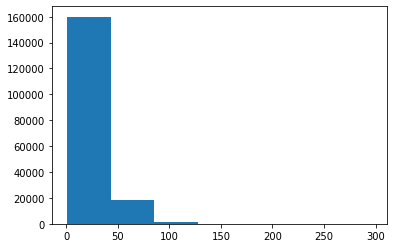

In [114]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [115]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [116]:
# Maximum sentence length in the training set
max(sent_lens)

296

In [117]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [118]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [119]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
a qualitative phenomenological method with purposive sampling was used in the study .

Length of text: 13

Vectorized text:
[[    8  1662 29349   363     7 15544  2382    10    98     5     2    17
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [120]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [121]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [122]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
a qualitative phenomenological method with purposive sampling was used in the study .

Sentence after vectorization (before embedding):
[[    8  1662 29349   363     7 15544  2382    10    98     5     2    17
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01587905  0.04488862  0.01580471 ...  0.02829877 -0.03538059
   -0.00450712]
  [ 0.02468148  0.01645604  0.00250024 ...  0.01249138  0.0127557
    0.00090312]
  [ 0.04786879  0.04610909  0.03349998 ...  0.01181684 -0.01200467
   -0.02408653]
  ...
  [-0.02349509 -0.0292951  -0.02117382 ... -0.02229103 -0.02087981
   -0.03367435]
  [-0.02349509 -0.0292951  -0.02117382 ... -0.02229103 -0.02087981
   -0.03367435]
  [-0.02349509 -0.0292951  -0.02117382 ... -

In [123]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [124]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [125]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Get summary of Conv1D model
model_1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 5)                 325 

In [126]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 63s 110ms/step - loss: 0.9172 - accuracy: 0.6363 - val_loss: 0.6785 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 62s 110ms/step - loss: 0.6537 - accuracy: 0.7569 - val_loss: 0.6314 - val_accuracy: 0.7663
Epoch 3/3
562/562 [==============================] - 60s 107ms/step - loss: 0.6164 - accuracy: 0.7740 - val_loss: 0.5956 - val_accuracy: 0.7856


In [127]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 6s 7ms/step


array([[4.0886915e-01, 1.7440869e-01, 8.0037788e-02, 3.1083846e-01,
        2.5845878e-02],
       [5.0637072e-01, 2.2116981e-01, 1.2847838e-02, 2.5299254e-01,
        6.6190227e-03],
       [1.5306033e-01, 5.7654553e-03, 1.1462767e-03, 8.3998960e-01,
        3.8295209e-05],
       ...,
       [3.2045414e-06, 5.7605718e-04, 5.7840307e-04, 4.9377918e-06,
        9.9883741e-01],
       [5.6749489e-02, 4.4801539e-01, 1.3290595e-01, 7.0664719e-02,
        2.9166454e-01],
       [1.6520955e-01, 6.8416804e-01, 4.9677007e-02, 3.4165911e-02,
        6.6779509e-02]], dtype=float32)

In [128]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60783794518734,
 'precision': 0.7828638666072822,
 'recall': 0.7860783794518734,
 'f1': 0.7838683343968853}

# Model 2: Feature extraction with pretrained token embeddings

In [129]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [130]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the alters ' drinking and criminal history were not significantly predictive of retention in the network .

Sentence after embedding:
[ 0.00284089 -0.01089423 -0.07051133 -0.00700496  0.01380757  0.02497767
  0.01064079  0.0186692  -0.01224914 -0.01863398 -0.01698825 -0.03971011
 -0.00141616  0.05383679 -0.09250259 -0.04669588 -0.02457337  0.04819103
  0.0001622   0.05526886 -0.06054864  0.0773488  -0.00633177 -0.01474901
 -0.01479295  0.01201648  0.0878578   0.01941881  0.00924333 -0.06101265] (truncated output)...

Length of sentence embedding:
512


In [131]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [132]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 17ms/step - loss: 0.9143 - accuracy: 0.6527 - val_loss: 0.7960 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7680 - accuracy: 0.7023 - val_loss: 0.7549 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7512 - accuracy: 0.7131 - val_loss: 0.7400 - val_accuracy: 0.7128


In [133]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7412 - accuracy: 0.7131


[0.7412188053131104, 0.7131272554397583]

In [134]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[4.1913417e-01, 3.6747360e-01, 1.7495404e-03, 2.0469734e-01,
        6.9452445e-03],
       [3.4601215e-01, 4.6507445e-01, 2.8342342e-03, 1.8299530e-01,
        3.0838819e-03],
       [2.3320462e-01, 1.4389008e-01, 1.5639268e-02, 5.7486033e-01,
        3.2405693e-02],
       ...,
       [1.6008622e-03, 6.3347006e-03, 5.7329357e-02, 7.7378610e-04,
        9.3396133e-01],
       [4.4045709e-03, 5.0481442e-02, 2.0230284e-01, 1.3450028e-03,
        7.4146610e-01],
       [1.9205555e-01, 2.4219774e-01, 5.0148010e-01, 7.8542177e-03,
        5.6412380e-02]], dtype=float32)

In [135]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.31272342115716,
 'precision': 0.7132691984344112,
 'recall': 0.7131272342115715,
 'f1': 0.7102112374497056}

# Model 3: Conv1D with character embeddings

In [136]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

"t h e   a l t e r s   '   d r i n k i n g   a n d   c r i m i n a l   h i s t o r y   w e r e   n o t   s i g n i f i c a n t l y   p r e d i c t i v e   o f   r e t e n t i o n   i n   t h e   n e t w o r k   ."

In [137]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [138]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

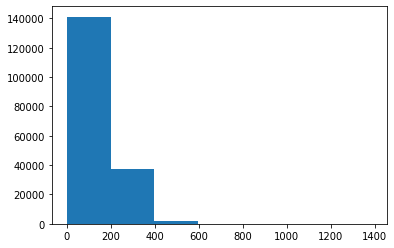

In [139]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [140]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [141]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [142]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
s u b j e c t s   w e r e   t r i a l   p a r t i c i p a n t s   w i t h   n u r s e - a s s e s s e d   g l o b a l   c o s m e t i c   s c o r e s   a t   b a s e l i n e   a n d   a t   @ y e a r s   .

Length of chars: 89

Vectorized chars:
[[ 9 16 22 27  2 11  3  9 20  2  8  2  3  8  4  5 12 14  5  8  3  4 11  4
  14  5  6  3  9 20  4  3 13  6 16  8  9  2  5  9  9  2  9  9  2 10 18 12
   7 22  5 12 11  7  9 15  2  3  4 11  9 11  7  8  2  9  5  3 22  5  9  2
  12  4  6  2  5  6 10  5  3 19  2  5  8  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [143]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
s u b j e c t s   w e r e   t r i a l   p a r t i c i p a n t s   w i t h   n u r s e - a s s e s s e d   g l o b a l   c o s m e t i c   s c o r e s   a t   b a s e l i n e   a n d   a t   @ y e a r s   .

Embedded chars (after vectorization and embedding):
[[[ 0.03978374  0.03721264 -0.00835752 ... -0.00122083 -0.00803403
    0.00585578]
  [-0.01227859  0.04833368 -0.03056213 ... -0.01741191 -0.01924851
    0.02337805]
  [ 0.02480463 -0.02698038 -0.04611815 ... -0.0452782   0.0061651
    0.04466558]
  ...
  [-0.01201795  0.04661718 -0.03757761 ...  0.03133062 -0.0425217
    0.00984009]
  [-0.01201795  0.04661718 -0.03757761 ...  0.03133062 -0.0425217
    0.00984009]
  [-0.01201795  0.04661718 -0.03757761 ...  0.03133062 -0.0425217
    0.00984009]]]

Character embedding shape: (1, 290, 25)


In [144]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 5

In [145]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 48ms/step - loss: 1.2529 - accuracy: 0.4952 - val_loss: 1.0286 - val_accuracy: 0.5818
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9971 - accuracy: 0.5975 - val_loss: 0.9371 - val_accuracy: 0.6237
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9215 - accuracy: 0.6368 - val_loss: 0.8668 - val_accuracy: 0.6612


In [146]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.8813 - accuracy: 0.6573


[0.8812957406044006, 0.6572554111480713]

In [147]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 15s 16ms/step


array([[0.16042858, 0.46222013, 0.09519377, 0.19385013, 0.08830737],
       [0.3690805 , 0.39858633, 0.02017276, 0.11491986, 0.09724046],
       [0.1610006 , 0.2728462 , 0.11241311, 0.37020463, 0.08353527],
       ...,
       [0.01292358, 0.04883843, 0.0683979 , 0.02857339, 0.84126663],
       [0.03570206, 0.21707001, 0.23229434, 0.0734482 , 0.44148532],
       [0.3627532 , 0.34081438, 0.19579925, 0.07075983, 0.02987334]],
      dtype=float32)

In [148]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.72553952072025,
 'precision': 0.6468285021046956,
 'recall': 0.6572553952072024,
 'f1': 0.6459774645333985}

# Model 4: Combining pretrained token embeddings + character embeddings(hybrid embedding layer)

In [149]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

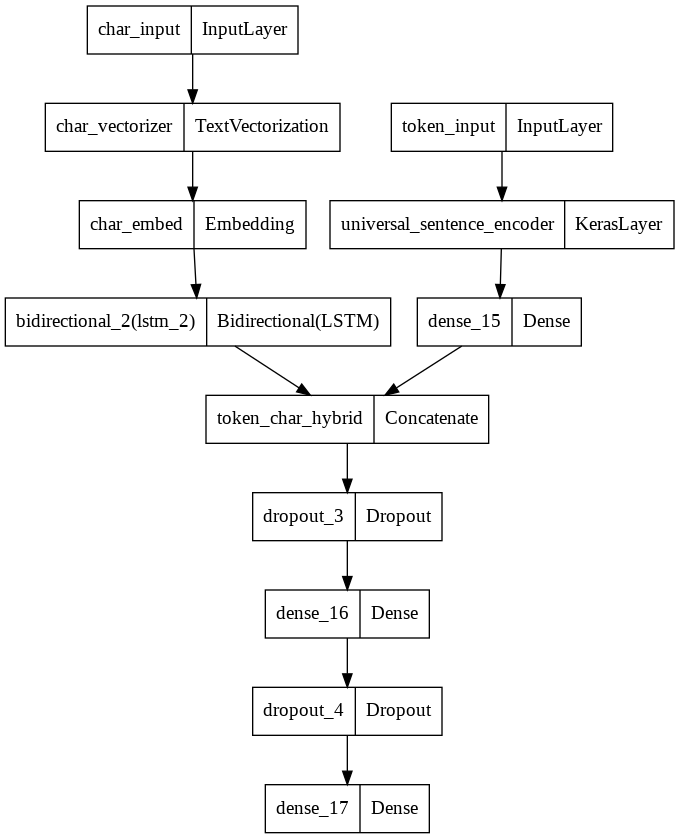

In [150]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [151]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [152]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [153]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 148s 255ms/step - loss: 0.9717 - accuracy: 0.6112 - val_loss: 0.7821 - val_accuracy: 0.7008
Epoch 2/3
562/562 [==============================] - 116s 207ms/step - loss: 0.7962 - accuracy: 0.6917 - val_loss: 0.7159 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 119s 211ms/step - loss: 0.7672 - accuracy: 0.7072 - val_loss: 0.6913 - val_accuracy: 0.7367


In [154]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 46s 49ms/step - loss: 0.6939 - accuracy: 0.7349


[0.693898618221283, 0.7348735332489014]

In [155]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 46s 47ms/step


array([[4.2515159e-01, 4.0312237e-01, 2.1104747e-03, 1.6421853e-01,
        5.3970935e-03],
       [4.0916178e-01, 3.8454238e-01, 1.5926440e-03, 2.0365573e-01,
        1.0475044e-03],
       [2.9501677e-01, 9.2903331e-02, 4.0984083e-02, 5.4766250e-01,
        2.3433199e-02],
       ...,
       [6.6475855e-04, 1.2335528e-02, 5.5352874e-02, 2.9601908e-04,
        9.3135083e-01],
       [5.4910984e-03, 5.1265761e-02, 2.1400572e-01, 2.5045115e-03,
        7.2673297e-01],
       [2.3234501e-01, 4.8981404e-01, 2.1982309e-01, 1.9461121e-02,
        3.8556766e-02]], dtype=float32)

In [156]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.4873560174765,
 'precision': 0.733742254423427,
 'recall': 0.734873560174765,
 'f1': 0.7319103140702575}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [157]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [158]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

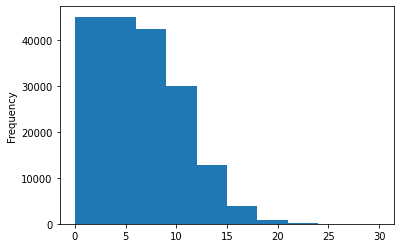

In [159]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [160]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [161]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

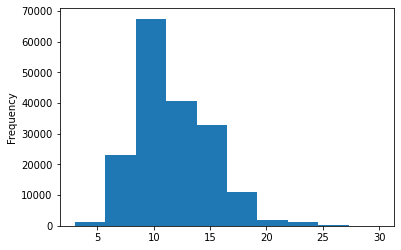

In [162]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [163]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [164]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [165]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [166]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

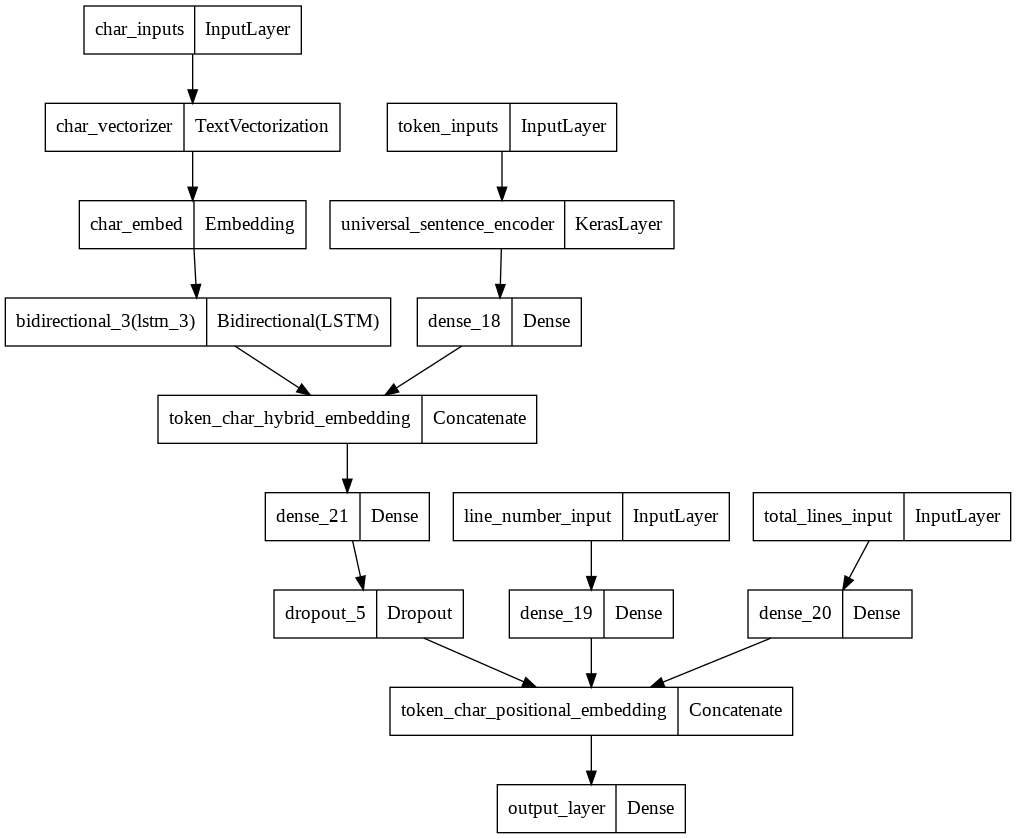

In [167]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [168]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f49a9845450> True
<keras.engine.input_layer.InputLayer object at 0x7f49a9834e50> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f49a608e2d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f49a1c73f90> False
<keras.layers.core.embedding.Embedding object at 0x7f49a98c04d0> True
<keras.layers.core.dense.Dense object at 0x7f49a9845350> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f49aecfcd90> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f49aea028d0> True
<keras.engine.input_layer.InputLayer object at 0x7f49a9822a10> True
<keras.engine.input_layer.InputLayer object at 0x7f49a71c4590> True
<keras.layers.core.dense.Dense object at 0x7f49a97c0150> True
<keras.layers.core.dense.Dense object at 0x7f49ae9f9bd0> True
<keras.layers.core.dense.Dense object at 0x7f49a9806f50> True
<keras.layers.regularization.dropout.Dropout object at 0x7f49aea9ffd0> True
<keras.layers

In [169]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [170]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [171]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 147s 253ms/step - loss: 1.1002 - accuracy: 0.7209 - val_loss: 0.9856 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 134s 239ms/step - loss: 0.9687 - accuracy: 0.8150 - val_loss: 0.9502 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 122s 217ms/step - loss: 0.9519 - accuracy: 0.8236 - val_loss: 0.9404 - val_accuracy: 0.8295


In [172]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 54s 55ms/step


array([[0.49559936, 0.11818547, 0.01085884, 0.35262975, 0.0227264 ],
       [0.5557528 , 0.09866739, 0.05113268, 0.28376558, 0.0106814 ],
       [0.26810387, 0.09585249, 0.12017795, 0.44997647, 0.06588916],
       ...,
       [0.04042075, 0.10937429, 0.03989994, 0.04010206, 0.77020293],
       [0.03407802, 0.32251015, 0.07613972, 0.0302259 , 0.5370462 ],
       [0.20614868, 0.5896331 , 0.08660743, 0.04366409, 0.07394665]],
      dtype=float32)

In [173]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.19541903879252,
 'precision': 0.8316517061435592,
 'recall': 0.8319541903879253,
 'f1': 0.8307216385392723}

#Comparing Models

In [174]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.607838,0.782864,0.786078,0.783868
pretrained_token_embed,71.312723,0.713269,0.713127,0.710211
custom_char_embed_conv1d,65.725540,0.646829,0.657255,0.645977
hybrid_char_token_embed,73.487356,0.733742,0.734874,0.731910
tribrid_pos_char_token_embed,83.195419,0.831652,0.831954,0.830722


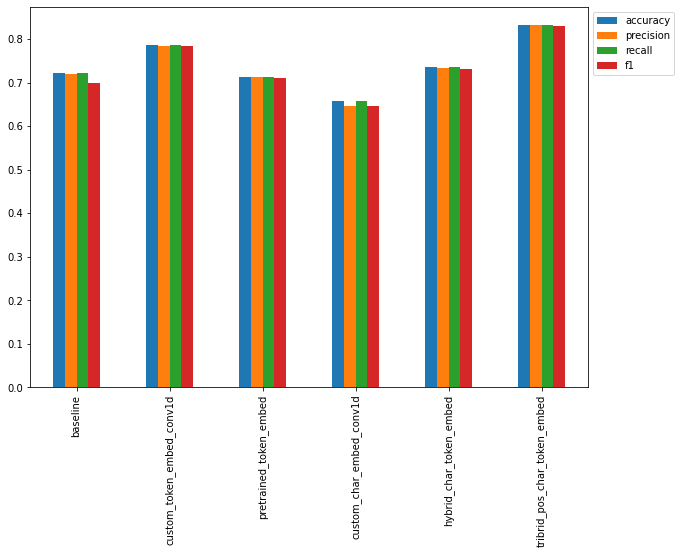

In [175]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

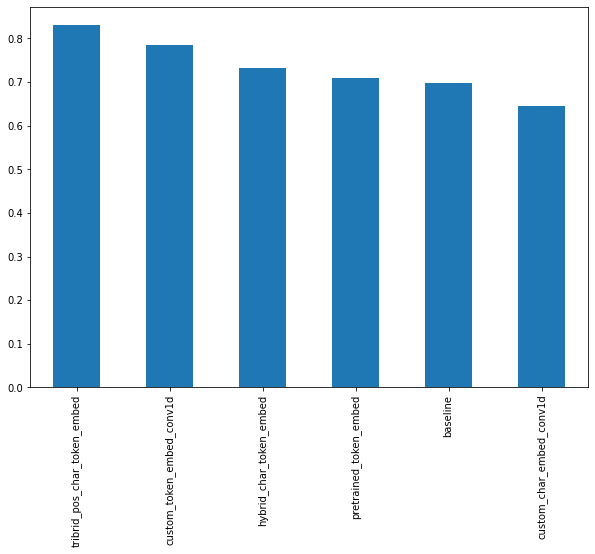

In [176]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Save and Load Best Performing Model

In [177]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [178]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-11-27 15:52:54--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  27.1MB/s    in 35s     

2022-11-27 15:53:29 (26.6 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras

In [182]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "/content/skimlit_tribrid_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file 
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

In [183]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 48s 50ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [184]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.19541903879252,
 'precision': 0.8316517061435592,
 'recall': 0.8319541903879253,
 'f1': 0.8307216385392723}

In [185]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [186]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

# Evaluating Model on Test DataSet

In [187]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 46s 49ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [188]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.87041645926664,
 'precision': 0.8276196354146768,
 'recall': 0.8287041645926664,
 'f1': 0.8273911750036022}

# Finding Most Wrong Predictions

In [189]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 5.25 s, sys: 7.26 ms, total: 5.25 s
Wall time: 5.26 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULT

In [190]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.475659,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.341864,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.787482,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.660773,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.725259,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.861246,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.538185,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.532730,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.451334,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.566471,True


In [191]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.948102,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.937412,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.933800,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.929894,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.921153,False
...,...,...,...,...,...,...,...
9871,RESULTS,secondary endpoints were each component of the...,3,8,METHODS,0.836536,False
18789,BACKGROUND,these programs were evaluated in a head-to-hea...,3,12,METHODS,0.835424,False
23590,BACKGROUND,to study the antioxidative and hepatoprotectiv...,2,12,OBJECTIVE,0.835332,False
24825,OBJECTIVE,", group b ( @ pts . )",3,11,METHODS,0.832465,False


In [192]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9481019973754883, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9374123811721802, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.933800220489502, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9298943877220154, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9211533665657043, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9189136624336243, Line number: 19, Total lines: 19

Text:
clinicaltrials.gov identifier : nct@ .

-----

Target: RE

# Sample Prediction

In [196]:
# Download and open example abstracts (copy and pasted from PubMed)
import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("/content/skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2022-11-27 16:03:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.3’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-11-27 16:03:11 (60.2 MB/s) - ‘skimlit_example_abstracts.json.3’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [197]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [201]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
#sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe("sentencizer") # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [202]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [206]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [212]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [213]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [214]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

1/1 [==============================] - 1s 1s/step
CPU times: user 1.54 s, sys: 21.1 ms, total: 1.56 s
Wall time: 1.54 s


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [215]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
